In [1]:
import random
import os
from torch.utils.data import Dataset
from IPython.display import clear_output
from PIL import Image
from tqdm import tqdm as train_loader_tqdm
from IPython.display import clear_output
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import torch
from tqdm import tqdm
import os


def shuffle_lists(list1, list2, seed=None):
    if seed is not None:
        random.seed(seed)
    combined_lists = list(zip(list1, list2))
    random.shuffle(combined_lists)
    shuffled_list1, shuffled_list2 = zip(*combined_lists)
    shuffled_list1 = list(shuffled_list1)
    shuffled_list2 = list(shuffled_list2)
    return shuffled_list1, shuffled_list2


class Data(Dataset):
    def __init__(self, data_folder, train = True, train_size = 0.9, transform=None, seed=42):
        super().__init__()
        self.train = train
        self.transform = transform
        self.decode = ['Downy Mildew', 'Bacterial Wilt', 'Fresh Leaf', 'Anthracnose', 'Gummy Stem Blight']
        self.paths = [data_folder + '/' * (data_folder[-1] != '/') + i for i in self.decode]
        images, classes = [], []
        for number_class, path in enumerate(self.paths):
            data = [path + '/' * (path[-1] != '/') + i for i in os.listdir(path)]
            images += data
            classes += [number_class] * len(data)

        images, classes = shuffle_lists(images, classes, seed=seed)
        n = int(len(images) * train_size)
        if train:
            self.classes = classes[:n]
            self.images = self._load_images(images[:n])
        else:
            self.classes = classes[n+1:]
            self.images = self._load_images(images[n+1:])

    def decode_class(self, _class):
        if 0 <= _class <= len(self.decode):
            return self.decode[_class]
        return -1
    def _load_images(self, image_paths):
        images = []
        cnt = 0
        for filename in image_paths:
            if cnt % 10 == 0:
                clear_output()
                print(f'{cnt}/{len(image_paths)}')
            cnt += 1
            image = Image.open(filename).convert('RGB')

            images += [image]
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        label = self.classes[item]
        image = self.images[item]
        image = self.transform(image)
        return image, label

In [2]:
import torch
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs, path_to_save):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    max_test_accuracy = 0
    best_weights = None
    for epoch in range(1, num_epochs + 1):
        print(scheduler.get_last_lr())
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        if test_accuracy > max_test_accuracy:
            max_test_accuracy = test_accuracy
            torch.save(model.state_dict(), path_to_save)
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

In [3]:
path_resized = '/kaggle/input/final-data/datasets/dataset_resized'
path_segmented_emperic = '/kaggle/input/final-data/datasets/dataset_segmented_emperic'
path_segmented_nn = '/kaggle/input/final-data/datasets/dataset_segmented_nn'

In [33]:
transform = T.Compose([
    T.ToTensor(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = Data(path_segmented_emperic, transform=transform, train=True,seed=45)
test_dataset = Data(path_segmented_emperic, train=False, transform=transform, seed=45)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=2)

70/79


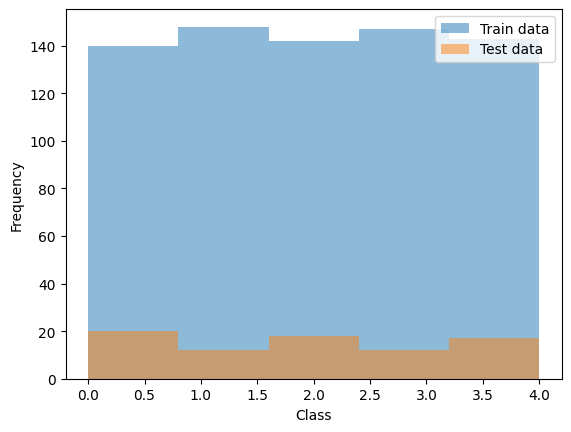

In [6]:
data1 = train_dataset.classes
data2 = test_dataset.classes

# Гистограмма для первого массива
plt.hist(data1, bins=5, alpha=0.5, label='Train data')

# Гистограмма для второго массива
plt.hist(data2, bins=5, alpha=0.5, label='Test data')

# Добавляем легенду
plt.legend()

# Добавляем название графика и осей
plt.xlabel('Class')
plt.ylabel('Frequency')

# Отображаем график
plt.show()

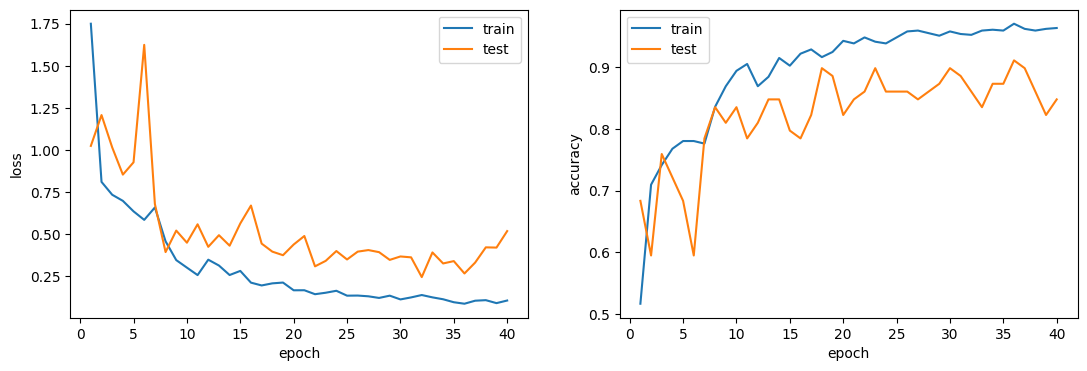

In [34]:
# Pipeline (default data)

model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_gpunet', pretrained=True, model_type='GPUNet-D2').to(device)
num_epochs = 40
optimizer = torch.optim.NAdam(model.parameters())
criterion = torch.nn.functional.cross_entropy
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma=0.5)
path_to_save = '/kaggle/working/weights.pt'
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs, path_to_save)

In [45]:
# Testing

true_classes = test_dataset.classes
preds = []
model.eval()
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    logits = model(images)
    preds += logits.argmax(dim=1).tolist()

Resulting accuracy: 0.9620253164556962


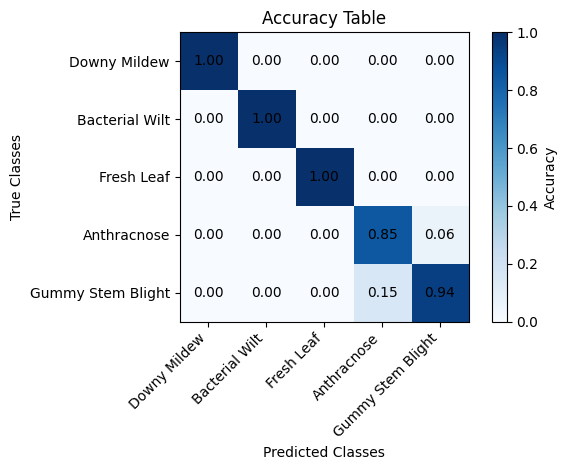

In [62]:
import numpy as np

def draw_accuracy_table_with_values(true_classes, predicted_classes, class_names):
    num_classes = len(class_names)
    accuracy_table = np.zeros((num_classes, num_classes))

    for i in range(len(true_classes)):
        true_class_idx = true_classes[i]
        predicted_class_idx = predicted_classes[i]
        accuracy_table[true_class_idx][predicted_class_idx] += 1

    col_sum = np.sum(accuracy_table, axis=0)
    accuracy_table_normalized = accuracy_table / col_sum

    plt.imshow(accuracy_table_normalized, cmap='Blues', interpolation='nearest')
    plt.title('Accuracy Table')
    plt.xlabel('Predicted Classes')
    plt.ylabel('True Classes')
    plt.xticks(range(num_classes), class_names, rotation=45, ha='right')
    plt.yticks(range(num_classes), class_names)
    plt.colorbar(label='Accuracy')

    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, f'{accuracy_table_normalized[i, j]:.2f}', ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()

truth = [int(true_classes[i] == preds[i]) for i in range(len(true_classes))]
print(f'Resulting accuracy: {sum(truth)/len(truth)}')
draw_accuracy_table_with_values(true_classes, preds, train_dataset.decode)
# Как видим, лишь 2 класса у нас предсказываются не очень хорошо